In [95]:
import os
import bioimage

from interactive_m2unet import M2UnetInteractiveModel
import numpy as np
import imageio
import albumentations as A
from skimage.filters import threshold_otsu
from skimage.measure import label
# Uncomment to specify the gpu number
# os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import torch
torch.backends.cudnn.benchmark = True
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
from torchvision.utils import make_grid
import math


In [96]:
'''
Custom Dataset class.
Randomly samples subsets of available data as a form of data augmentation to create more data, parameterized by sub_samples
'''
class MyDataset(Dataset):
    
    def __init__(self, images_path ,transform_img=None ,transform_label=None, sub_samples = 1):
        
        self.images_path = images_path
        self.transform_img = transform_img
        self.transform_label = transform_label
        self.sub_samples = sub_samples
        self.files_list = [os.path.join(self.images_path, s) for s in os.listdir(self.images_path) if s.endswith('.npy')]
        
        print('dataset initialized')
        
    def __len__(self):
                
        
        return len(self.files_list)*self.sub_samples
        

    def __getitem__(self, idx):
        print('test')
        print(idx)
        # We use sub_samples to randomly sample large images to create more training data
        # Create num sub_samples of each image
        
        i = math.floor(idx/self.sub_samples)
        
        file = self.files_list[i]
        
        print(file)
        
        items = np.load(file, allow_pickle=True).item()

            
        # try:
        #     items = np.load(file, allow_pickle=True).item()
        # except:
        #     print("Bad Item")
            
        mask = (items['masks'][:, :, None]  > 0) * 1
        outline = (items['outlines'][:, :, None]  > 0) * 1
        mask = mask * (1 - outline)
        
        # print(items['img'].type)
        
        # Create random seed for transforms
        seed = np.random.randint(53434)
        
        # Use same same seed for label and image transform
        if self.transform_img:
            random.seed(seed)
            image = self.transform_img(items['img'])
            
            random.seed(seed)
            mask = np.uint8(mask)
            label = self.transform_img(mask)
            
            

        return image, label
    

    
mytransformsImage = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(sz),
        transforms.ToTensor(),
    ])

mytransformsLabel = transforms.Compose([
    transforms.ToPILImage(),
        transforms.RandomResizedCrop(sz),
        transforms.ToTensor(),
    ])



In [97]:
# batch_size = 64
# sub_samples = 1

# traindata = MyDataset(data_dir + '/train', mytransformsImage, mytransformsLabel, sub_samples)   
# train_loader = DataLoader(traindata,batch_size, shuffle = False)

# testdata = MyDataset(data_dir + '/test', mytransformsImage, mytransformsLabel, sub_samples = 5)   
# test_loader = DataLoader(traindata,batch_size)



In [99]:
from torchvision.transforms import ToTensor, Lambda

def load_samples(train_dir, size, sub_samples):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    sz = size
    transform = A.Compose(
    [
        A.RandomCrop(sz, sz),
        #A.Rotate(limit=[-5, 5], p=1),
        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.Flip(p=0.5),
        #A.CenterCrop(sz, sz),
    ])
    
    # data_transform = transforms.Compose([
    #     transforms.RandomResizedCrop(sz),
    #     transforms.ToTensor(),
    # ])
    
    
    npy_files = [os.path.join(train_dir, s) for s in os.listdir(train_dir) if s.endswith('.npy')]
    samples = []
    for file in npy_files:
        print(file)
        try:
            items = np.load(file, allow_pickle=True).item()
        except:
            print("Bad Item")
            continue
        
        
        mask = (items['masks'][:, :, None]  > 0) * 1.0
        outline = (items['outlines'][:, :, None]  > 0) * 1.0
        mask = mask * (1.0 - outline)
        # sample = (items['img'], mask)
        # sample_transform = transform(image = items['img'])
        # label_transform = transform(image  = mask)
        
        for i in range(sub_samples):
            transformed = transform(image=items['img'], mask= mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']

            transformed_image = np.swapaxes(transformed_image, 0, 2)
            transformed_mask = np.swapaxes(transformed_mask, 0, 2)
            
            transformed_image = torch.tensor(transformed_image)
            transformed_mask = torch.tensor(transformed_mask)

            
            image = transformed_image.float().to(device)
            image = image / 256 # pushing data between 0 and 1
            label = transformed_mask.float().to(device)

            sample = (image, label)

            samples.append(sample)
    
        
        # sample_transform = data_transform(items['img'])
        # label_transform = data_transform(mask)
        
        
    return samples

# Load data into Dataloader

data_dir = './cell_data_3' # data should contain a train and a test folder

size = 512
sub_samples = 4

train_samples = load_samples(data_dir + '/train', size, sub_samples)
test_samples = load_samples(data_dir + '/test',size, sub_samples)

# Load data into Dataloader

# for (images, labels) in enum
bs = 4
train_dataloader = DataLoader(train_samples, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_samples, batch_size=1, shuffle=True)



./cell_data_3/train/0_6_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/5_9_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/2_3_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/0_9_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/1_4_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/6_4_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/0_2_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/8_2_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/8_3_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/2_6_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/9_8_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/6_2_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/5_7_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/0_7_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/1_5_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/2_0_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/9_4_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/5_0_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/7_4_f_BF_LED_matrix_dpc_seg.npy
./cell_data_

In [100]:
# Load data into Dataloader

data_dir = './cell_data_3' # data should contain a train and a test folder

size = 512
sub_samples = 4

train_samples = load_samples(data_dir + '/train', size, sub_samples)
test_samples = load_samples(data_dir + '/test',size, sub_samples)

# Load data into Dataloader

# for (images, labels) in enum
bs = 4
train_dataloader = DataLoader(train_samples, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_samples, batch_size=1, shuffle=True)

print(len(train_dataloader))


# test_dataloader = DataLoader(test_samples, batch_size=64, shuffle=True)

# train_transformed = torchvision.datasets(train_samples, transform = data_transform)

train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
# print(img.shape)
# label = train_labels[0]
# plt.imshow(img, cmap="gray")
# plt.show()
# print(f"Label: {label}")
# trainloader = DataLoader(train_transformed, batch_size=1, shuffle=False, train = True)



./cell_data_3/train/0_6_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/5_9_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/2_3_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/0_9_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/1_4_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/6_4_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/0_2_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/8_2_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/8_3_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/2_6_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/9_8_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/6_2_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/5_7_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/0_7_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/1_5_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/2_0_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/9_4_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/5_0_f_BF_LED_matrix_dpc_seg.npy
./cell_data_3/train/7_4_f_BF_LED_matrix_dpc_seg.npy
./cell_data_

In [104]:
## Defines Unet

import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
# from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

class Convblock(nn.Module):
    
      def __init__(self,input_channel,output_channel,kernal=3,stride=1,padding=1):
            
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernal,stride,padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernal),
            nn.ReLU(inplace=True),
        )
    

      def forward(self,x):
        x = self.convblock(x)
        return x
    
class UNet(nn.Module):
    
    def __init__(self,input_channel,retain=True):

        super().__init__()

        self.conv1 = Convblock(input_channel,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,1,1,1)
        self.retain = retain
        
    def forward(self,x):
        
        # Encoder Network
        
        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)

        # BottelNeck
        neck = self.neck(pool4)
        
        # Decoder Network
        
        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        # Output Layer
        out = self.out(dconv1)
        
        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])

        return out
    
    def crop(self,input_tensor,target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)
    

In [105]:
# initializing the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet(3).float().to(device)
print(model)

cuda:0
UNet(
  (conv1): Convblock(
    (convblock): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU(inplace=True)
    )
  )
  (conv2): Convblock(
    (convblock): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU(inplace=True)
    )
  )
  (conv3): Convblock(
    (convblock): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_si

In [ ]:
# device = 'cuda:0'
lr = 0.01
epochs = 30
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for i in range(epochs):
    
    trainloss = 0
    valloss = 0
    
    for img,label in tqdm(train_dataloader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        # img = img.float().to(device)
        # img = img / 256 # pushing data between 0 and 1
        # label = label.float().to(device)
        output = model(img)
        loss = lossfunc(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()
    
    # if(i%5==0):
    #     show(img,output,label)

    train_loss.append(trainloss/len(train_dataloader))    
    
  
    for img,label in tqdm(test_dataloader):
        '''
            Validation of Model.
        '''
        # img = img.float().to(device)
        # img = img / 256 # pushing data between 0 and 1

        label = label.float().to(device)
        output = model(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()
        
    val_loss.append(valloss/len(test_dataloader))  
    
    
    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

100%|██████████| 80/80 [00:00<00:00, 115.92it/s]


epoch : 0 ,train loss : 0.37027430478483436 ,valid loss : 0.2525166917592287 


100%|██████████| 80/80 [00:00<00:00, 116.10it/s]


epoch : 1 ,train loss : 0.2502653578296304 ,valid loss : 0.24997219815850258 


100%|██████████| 80/80 [00:00<00:00, 115.91it/s]


epoch : 2 ,train loss : 0.2499707153066993 ,valid loss : 0.24998770132660866 


100%|██████████| 80/80 [00:00<00:00, 115.77it/s]


epoch : 3 ,train loss : 0.24997694101184606 ,valid loss : 0.2499723019078374 


100%|██████████| 80/80 [00:00<00:00, 115.80it/s]


epoch : 4 ,train loss : 0.2499952966347337 ,valid loss : 0.24996909853070975 


100%|██████████| 80/80 [00:00<00:00, 115.75it/s]


epoch : 5 ,train loss : 0.2500077297911048 ,valid loss : 0.24996913075447083 


100%|██████████| 80/80 [00:00<00:00, 115.55it/s]


epoch : 6 ,train loss : 0.24999966640025378 ,valid loss : 0.24997764825820923 


100%|██████████| 80/80 [00:00<00:00, 115.80it/s]


epoch : 7 ,train loss : 0.25000132657587526 ,valid loss : 0.24996975362300872 


100%|██████████| 80/80 [00:00<00:00, 115.58it/s]


epoch : 8 ,train loss : 0.24997888840734958 ,valid loss : 0.25002524331212045 


100%|██████████| 80/80 [00:00<00:00, 115.79it/s]


epoch : 9 ,train loss : 0.24998666644096373 ,valid loss : 0.2499803828075528 


100%|██████████| 80/80 [00:00<00:00, 115.69it/s]


epoch : 10 ,train loss : 0.24999422784894704 ,valid loss : 0.24999641571193934 


100%|██████████| 80/80 [00:00<00:00, 115.63it/s]


epoch : 11 ,train loss : 0.24996366910636425 ,valid loss : 0.2500146485865116 


100%|██████████| 80/80 [00:00<00:00, 115.73it/s]


epoch : 12 ,train loss : 0.25000970009714363 ,valid loss : 0.2499697230756283 


100%|██████████| 80/80 [00:00<00:00, 114.84it/s]


epoch : 13 ,train loss : 0.25002346765249966 ,valid loss : 0.250020832195878 


100%|██████████| 80/80 [00:00<00:00, 115.48it/s]


epoch : 14 ,train loss : 0.24999407418072223 ,valid loss : 0.2499938452616334 


100%|██████████| 80/80 [00:00<00:00, 115.76it/s]


epoch : 15 ,train loss : 0.2499905377626419 ,valid loss : 0.24998465217649937 


100%|██████████| 80/80 [00:00<00:00, 116.01it/s]


epoch : 16 ,train loss : 0.2500010706484318 ,valid loss : 0.2499755121767521 


100%|██████████| 80/80 [00:00<00:00, 116.03it/s]


epoch : 17 ,train loss : 0.25000220686197283 ,valid loss : 0.24998366441577674 


100%|██████████| 80/80 [00:00<00:00, 116.06it/s]


epoch : 18 ,train loss : 0.2500424595549703 ,valid loss : 0.24998471699655056 


100%|██████████| 80/80 [00:00<00:00, 115.91it/s]


epoch : 19 ,train loss : 0.2500445146113634 ,valid loss : 0.2499768130481243 


100%|██████████| 80/80 [00:00<00:00, 115.97it/s]


epoch : 20 ,train loss : 0.25004271436482667 ,valid loss : 0.2502175185829401 


100%|██████████| 80/80 [00:00<00:00, 114.21it/s]


epoch : 21 ,train loss : 0.2500602724030614 ,valid loss : 0.24999785088002682 


100%|██████████| 80/80 [00:00<00:00, 116.03it/s]


epoch : 22 ,train loss : 0.250003987737 ,valid loss : 0.24998502247035503 


100%|██████████| 80/80 [00:00<00:00, 115.97it/s]


epoch : 23 ,train loss : 0.2500451259315014 ,valid loss : 0.24999711979180575 


100%|██████████| 80/80 [00:00<00:00, 115.81it/s]


epoch : 24 ,train loss : 0.25004085768014195 ,valid loss : 0.24998982790857555 


100%|██████████| 80/80 [00:00<00:00, 115.92it/s]


epoch : 25 ,train loss : 0.2500533290207386 ,valid loss : 0.2499890776351094 


100%|██████████| 80/80 [00:00<00:00, 116.04it/s]


epoch : 26 ,train loss : 0.24999897833913565 ,valid loss : 0.24997082725167274 


100%|██████████| 80/80 [00:00<00:00, 115.97it/s]


epoch : 27 ,train loss : 0.2499938288703561 ,valid loss : 0.2499740958213806 


100%|██████████| 80/80 [00:00<00:00, 115.90it/s]


epoch : 28 ,train loss : 0.25001851879060266 ,valid loss : 0.2500216893851757 


 42%|████▎     | 34/80 [00:01<00:02, 17.64it/s]

tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 1.]]]], device='cuda:0')


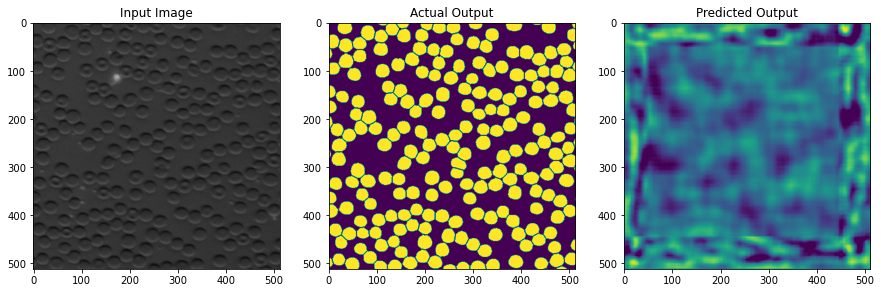

tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')


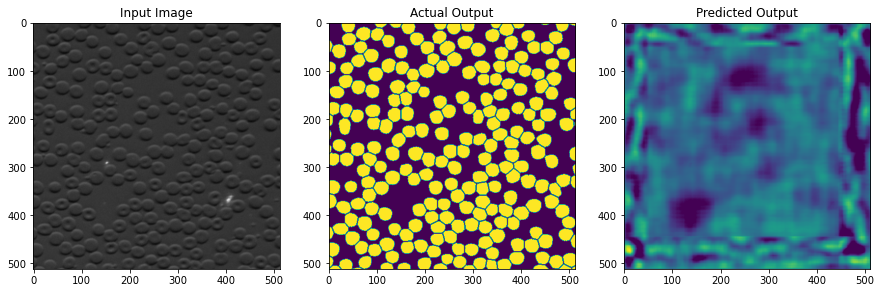

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]], device='cuda:0')


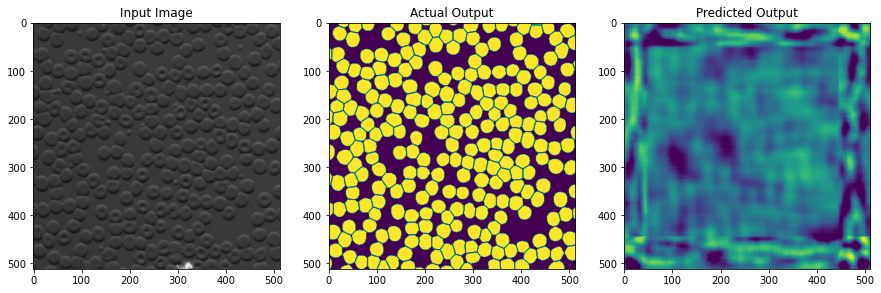

tensor([[[[0., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]], device='cuda:0')


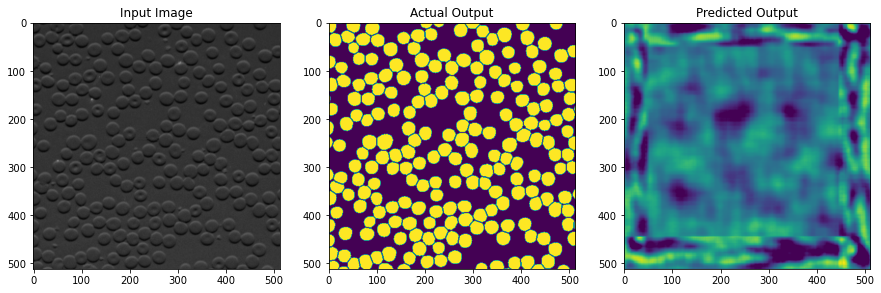

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


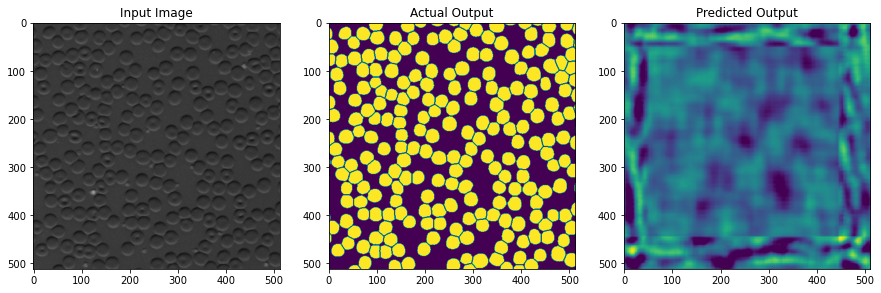

tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


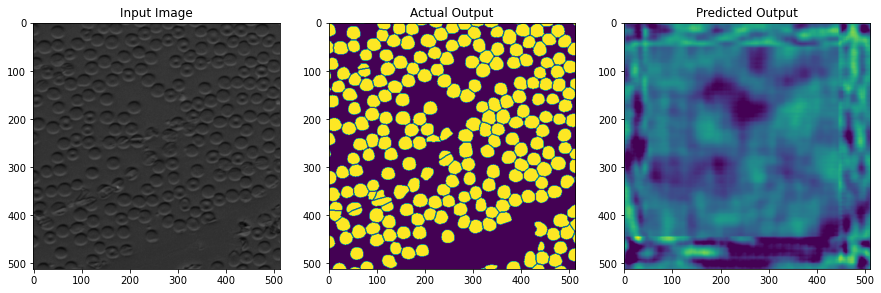

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')


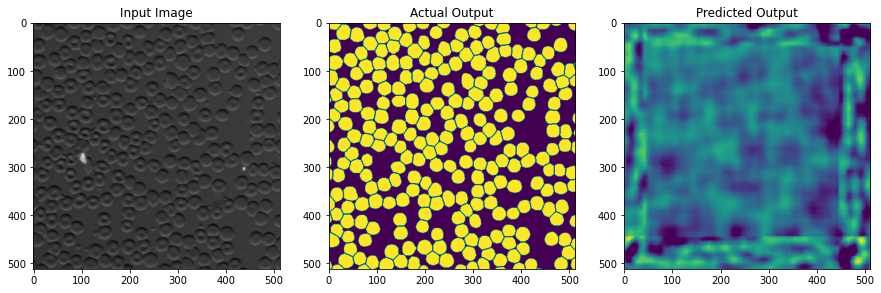

tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')


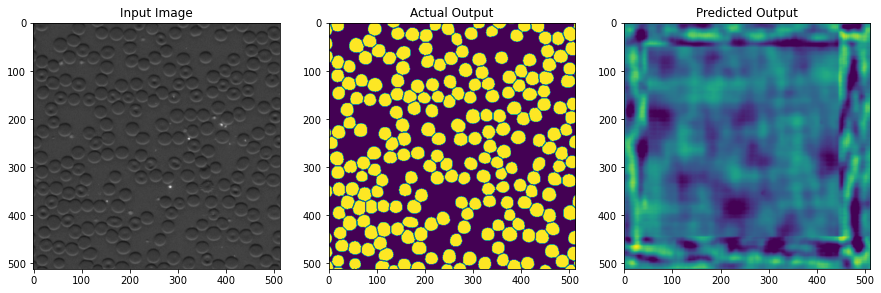

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]], device='cuda:0')


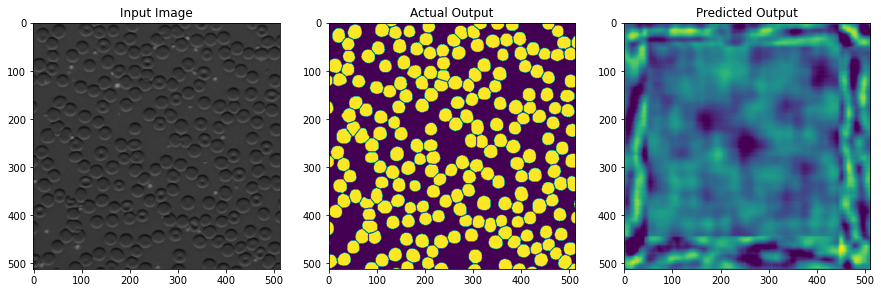

tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]], device='cuda:0')


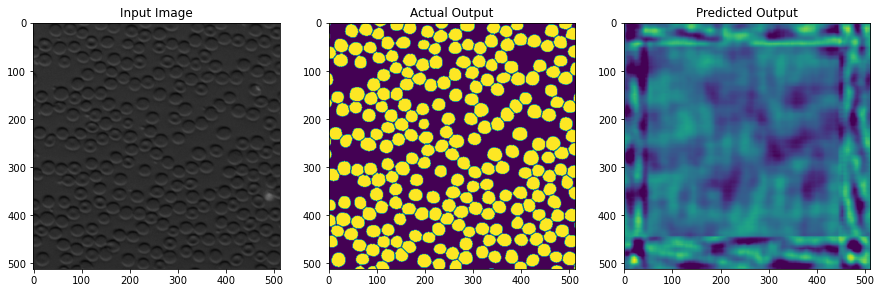

tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]], device='cuda:0')


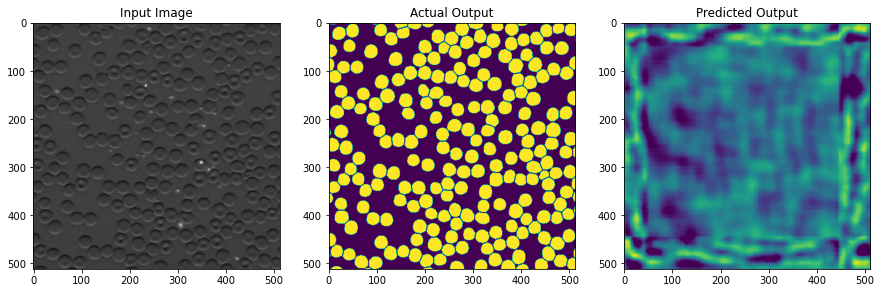

tensor([[[[1., 1., 1.,  ..., 1., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 0.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]], device='cuda:0')


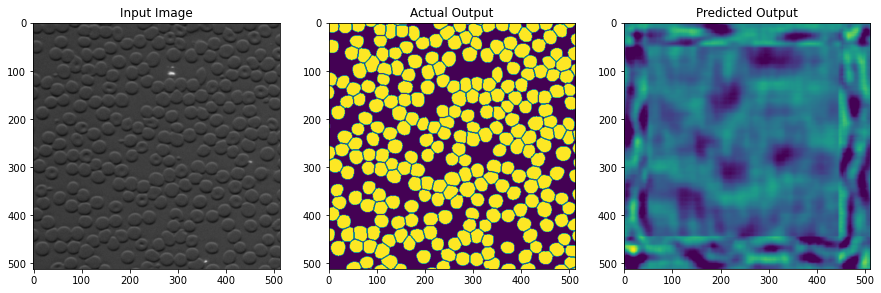

tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


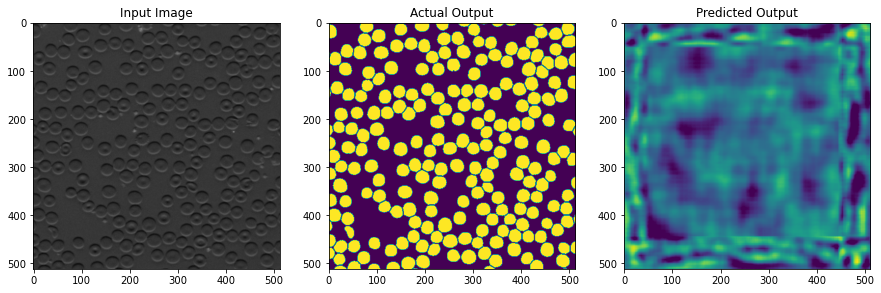

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


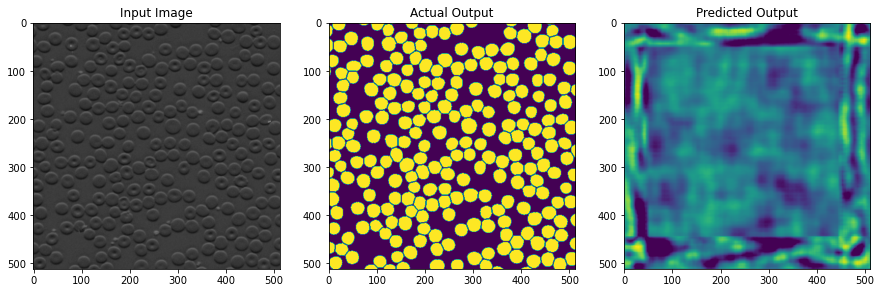

tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')


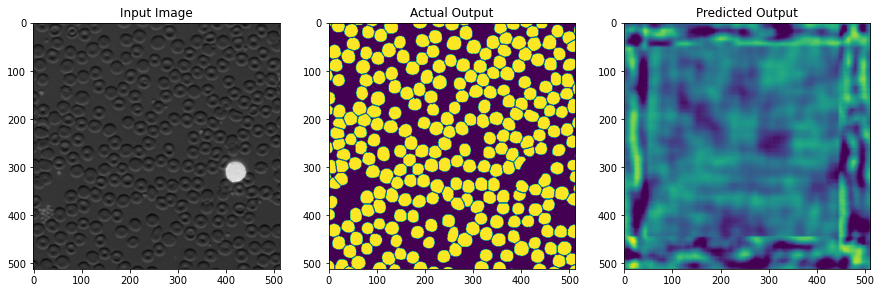

tensor([[[[0., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')


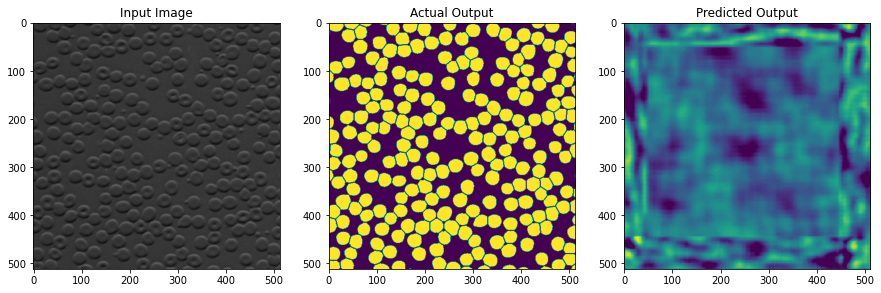

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


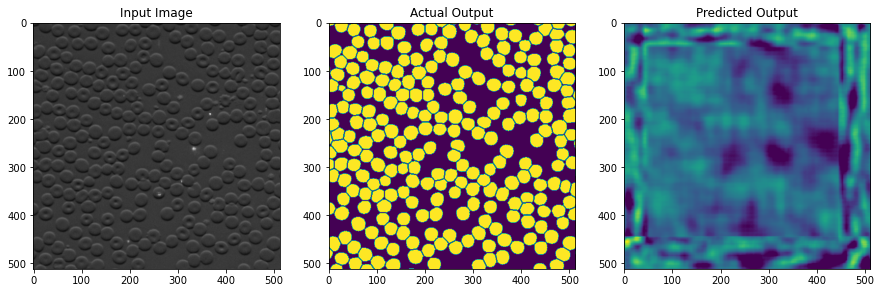

tensor([[[[1., 1., 1.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]], device='cuda:0')


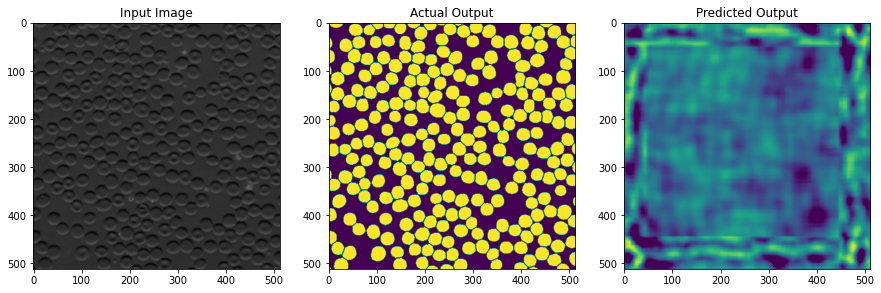

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]], device='cuda:0')


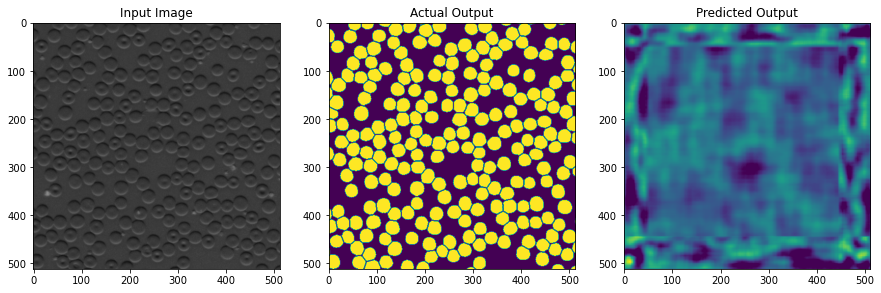

tensor([[[[1., 1., 0.,  ..., 0., 0., 1.],
          [1., 1., 0.,  ..., 0., 0., 1.],
          [1., 1., 0.,  ..., 0., 0., 1.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]], device='cuda:0')


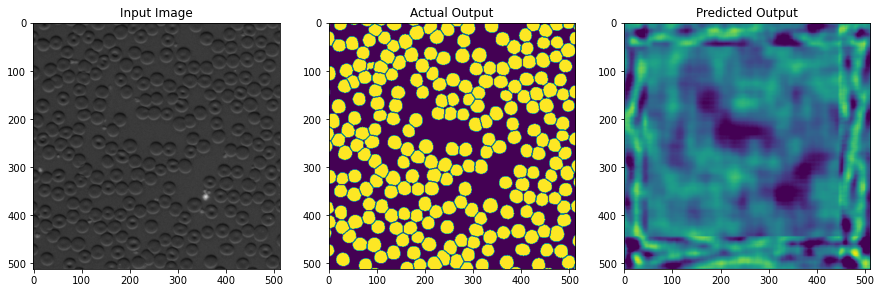

tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]], device='cuda:0')


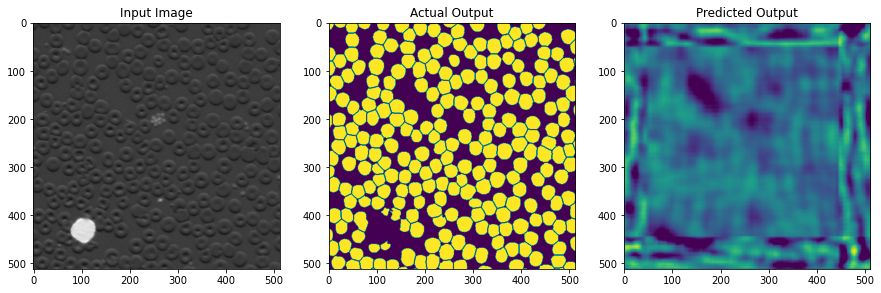

tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


KeyboardInterrupt: 

In [92]:
# Plot sample data
def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(15,30))
    cols = ['Input Image','Actual Output','Predicted Output']
    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][2].imshow(Lab)
            ax[i][1].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[2].imshow(Lab)
            ax[1].imshow(act.permute(1,2,0))
            #ax[0].title('this')
            for ax, col in zip(ax, cols):
                ax.set_title(col)
    plt.show()
    
c = 0
for img,label in (test_dataloader):
        # img = img.float().to(device)
        # img = img / 256
        print(label)
        label = label.float().to(device)
        output = model(img)
        show(img,output,label)
        if c>20:
            break
        c+=1

In [33]:
# Plot a sample 
sz = 512


Plot data sample



from skimage.filters import threshold_otsu
from skimage.measure import label
for i, sample in enumerate(test_dataloader):
    img, labels = sample
    img = img.float().to(device)
    labels = labels.float().to(device)
    print(labels)
    
    input_temp = img.cpu().detach().numpy().astype("float32")[None, :sz, :sz, :]
    temp = np.swapaxes(input_temp[0,0,:,:], 0, 2)
        
    # Write input image
    imageio.imwrite(f"octopi-inputs_{i}.png", temp.astype('uint8'))
    
    #Write label image
    label_temp = labels.cpu().detach().numpy().astype("float32")[None, :sz, :sz, :]
    temp = np.swapaxes(label_temp[0,0,:,:], 0, 2)
    print(temp.shape)
    print(temp)

    imageio.imwrite(f"octopi-labels_{i}.png", temp.astype('uint8'))
    
    # write predicted label image
    results = model(img)
    print(results.shape)
    result_temp = results.cpu().detach().numpy()
    print(result_temp.shape)
    temp = result_temp[0,:,:,:]
    print('result temp shape')
    print(temp.shape)
    
    output = np.clip(temp * 255, 0, 255)[:, :, :].astype('uint8')

    temp =  np.swapaxes(output, 0,2)
    print(temp.shape)
    imageio.imwrite(f"octopi-pred-prob_{i}.png", temp)
    
    print(np.mean(temp))
    
    threshold = threshold_otsu(temp)
    mask = ((output > threshold) * 255).astype('uint8')
    
    
    # print(mask.type)
    print(mask.shape)
    mask = np.swapaxes(mask, 0, 2)
    predict_labels = label(mask)
    imageio.imwrite(f"octopi-pred-labels_{i}.png", predict_labels)

print("all done")

SyntaxError: invalid syntax (186971298.py, line 5)

In [ ]:
# a function for loading cellpose output (image, mask and outline)


# check if GPU is available
print(f'GPU: {torch.cuda.is_available()}')

# setting up
data_dir = './cell_data_3' # data should contain a train and a test folder
model_root = "./models_100"
epochs = 2
steps = 1
resume = True
corrid = "200"
pretrained_model = None  # os.path.join(model_root, str(corrid), "model.h5")
os.makedirs(os.path.join(model_root, str(corrid)), exist_ok=True)
sz = 2048
sz_outer = int(sz* 1.5)

# define the transforms
transform = A.Compose(
    [
        A.RandomCrop(sz, sz),
        #A.Rotate(limit=[-5, 5], p=1),
        A.Flip(p=0.5),
        #A.CenterCrop(sz, sz),
    ]
)
A.save(transform, "./models/transform.json")
# unet model hyperparamer can be found here: https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=f899f7a8a9144b3f946c4a1362f7e38ae0c00c59&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f79696e676b61697368612f6b657261732d756e65742d636f6c6c656374696f6e2f663839396637613861393134346233663934366334613133363266376533386165306330306335392f6578616d706c65732f757365725f67756964655f6d6f64656c732e6970796e62&logged_in=true&nwo=yingkaisha%2Fkeras-unet-collection&path=examples%2Fuser_guide_models.ipynb&platform=mac&repository_id=323426984&repository_type=Repository&version=95#Swin-UNET
model_config = {
    "type": "m2unet",
    "activation": "sigmoid",
    "output_channels": 1,
    "loss": {"name": "BCELoss", "kwargs": {}},
    "optimizer": {"name": "RMSprop", "kwargs": {"lr": 1e-2, "weight_decay": 1e-8, "momentum": 0.9}}
    # "augmentation": A.to_dict(transform),
}
model = M2UnetInteractiveModel(
    model_config=model_config,
    model_dir=model_root,
    resume=resume,
    pretrained_model=pretrained_model,
    default_save_path=os.path.join(model_root, str(corrid), "model.pth"),
)

# # load samples
# train_samples = load_samples(data_dir + '/train')
# test_samples = load_samples(data_dir + '/test')

# train the model 
if TRAIN:
    iterations = 0
    for epoch in range(epochs):
        print('epoch: ')
        print(epoch)
        losses = []
        # image shape: sz, sz, 3
        # labels shape: sz, sz, 1
        for i, sample in enumerate(train_dataloader, 0):
            image, labels = sample
            mask = model.transform_labels(labels)
            x = np.expand_dims(image, axis=1)
            print(x.shape)
            y = np.expand_dims(mask, axis=1)
            print(x)
            print(y)
            losses = []
            for _ in range(steps):
                # x and y will be augmented for each step
                loss = model.train_on_batch(x, y)
                losses.append(loss)
                iterations += 1
                print(f"iteration: {iterations}, loss: {loss}")
    model.save()

# test
if TEST:
    for i, sample in enumerate(test_samples):
        inputs = sample[0].astype("float32")[None, :sz, :sz, :]
        imageio.imwrite(f"octopi-inputs_{i}.png", inputs[0].astype('uint8'))
        labels = sample[1].astype("float32")[None, :sz, :sz, :] * 255
        imageio.imwrite(f"octopi-labels_{i}.png", labels[0].astype('uint8'))
        results = model.predict(inputs)
        output = np.clip(results[0] * 255, 0, 255)[:, :, 0].astype('uint8')
        imageio.imwrite(f"octopi-pred-prob_{i}.png", output)
        threshold = threshold_otsu(output)
        mask = ((output > threshold) * 255).astype('uint8')
        predict_labels = label(mask)
        imageio.imwrite(f"octopi-pred-labels_{i}.png", predict_labels)

    print("all done")
    



In [ ]:
# Test
TEST = True
TRAIN = True

import numpy as np
import imageio
import albumentations as A
from skimage.filters import threshold_otsu
from skimage.measure import label
# Uncomment to specify the gpu number
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import torch
torch.backends.cudnn.benchmark = True

# a function for loading cellpose output (image, mask and outline)
def load_samples(train_dir):
    npy_files = [os.path.join(train_dir, s) for s in os.listdir(train_dir) if s.endswith('.npy')]
    samples = []
    for file in npy_files:
        print(file)
        try:
            items = np.load(file, allow_pickle=True).item()
        except:
            print("Bad Item")
            continue
        mask = (items['masks'][:, :, None]  > 0) * 1.0
        outline = (items['outlines'][:, :, None]  > 0) * 1.0
        mask = mask * (1.0 - outline)
        sample = (items['img'], mask)
        samples.append(sample)
    return samples

# check if GPU is available
print(f'GPU: {torch.cuda.is_available()}')

# setting up
data_dir = './cell_data_3' # data should contain a train and a test folder
model_root = "./models_100"
epochs = 1
steps = 1
resume = True
corrid = "200"
pretrained_model = None  # os.path.join(model_root, str(corrid), "model.h5")
os.makedirs(os.path.join(model_root, str(corrid)), exist_ok=True)
sz = 2048
sz_outer = int(sz* 1.5)

# define the transforms
transform = A.Compose(
    [
        A.RandomCrop(sz, sz),
        #A.Rotate(limit=[-5, 5], p=1),
        A.Flip(p=0.5),
        #A.CenterCrop(sz, sz),
    ]
)
A.save(transform, "./models/transform.json")
# unet model hyperparamer can be found here: https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=f899f7a8a9144b3f946c4a1362f7e38ae0c00c59&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f79696e676b61697368612f6b657261732d756e65742d636f6c6c656374696f6e2f663839396637613861393134346233663934366334613133363266376533386165306330306335392f6578616d706c65732f757365725f67756964655f6d6f64656c732e6970796e62&logged_in=true&nwo=yingkaisha%2Fkeras-unet-collection&path=examples%2Fuser_guide_models.ipynb&platform=mac&repository_id=323426984&repository_type=Repository&version=95#Swin-UNET
model_config = {
    "type": "m2unet",
    "activation": "sigmoid",
    "output_channels": 1,
    "loss": {"name": "BCELoss", "kwargs": {}},
    "optimizer": {"name": "RMSprop", "kwargs": {"lr": 1e-2, "weight_decay": 1e-8, "momentum": 0.9}},
    "augmentation": A.to_dict(transform),
}
model = M2UnetInteractiveModel(
    model_config=model_config,
    model_dir=model_root,
    resume=resume,
    pretrained_model=pretrained_model,
    default_save_path=os.path.join(model_root, str(corrid), "model.pth"),
)

# load samples
train_samples = load_samples(data_dir + '/train')
test_samples = load_samples(data_dir + '/test')

# train the model 
if TRAIN:
    iterations = 0
    for epoch in range(epochs):
        print('epoch: ')
        print(epoch)
        losses = []
        # image shape: sz, sz, 3
        # labels shape: sz, sz, 1
        for (image, labels) in train_samples:
            mask = model.transform_labels(labels)
            x = np.expand_dims(image, axis=0)
            y = np.expand_dims(mask, axis=0)
            losses = []
            for _ in range(steps):
                # x and y will be augmented for each step
                loss = model.train_on_batch(x, y)
                losses.append(loss)
                iterations += 1
                print(f"iteration: {iterations}, loss: {loss}")
    model.save()

# test
if TEST:
    for i, sample in enumerate(test_samples):
        inputs = sample[0].astype("float32")[None, :sz, :sz, :]
        imageio.imwrite(f"octopi-inputs_{i}.png", inputs[0].astype('uint8'))
        labels = sample[1].astype("float32")[None, :sz, :sz, :] * 255
        imageio.imwrite(f"octopi-labels_{i}.png", labels[0].astype('uint8'))
        results = model.predict(inputs)
        output = np.clip(results[0] * 255, 0, 255)[:, :, 0].astype('uint8')
        imageio.imwrite(f"octopi-pred-prob_{i}.png", output)
        threshold = threshold_otsu(output)
        mask = ((output > threshold) * 255).astype('uint8')
        predict_labels = label(mask)
        imageio.imwrite(f"octopi-pred-labels_{i}.png", predict_labels)

    print("all done")


In [ ]:
np.load('./072622-D5-6_2022-07-27_17-22-25.774065/3_0_f_BF_LED_matrix_dpc_seg.npy', allow_pickle=True).item()

In [ ]:
torch.cuda.is_available()

In [ ]:
# Jaccard Similarity
import numpy as np
import cv2
import glob

labels_str = "octopi-labels_"
pred_str = "octopi-pred-labels_"
imgs = glob.glob("*.png")
n_labels = len([i for i in imgs if labels_str in i])

def jaccard_sim(img1, img2):
    n = np.prod(img1.shape)
    a = img1 * img2
    b = img1 + img2 - a
    J = a/b
    J[np.isnan(J)] = 1
    j = np.sum(J)/n

    return j


j = []
for i in range(n_labels):
    label = labels_str + str(i) + ".png"
    pred  = pred_str + str(i) + ".png"

    i_pred = np.array(cv2.imread(pred)[:,:,0], dtype='f')
    i_label = np.array(cv2.imread(label)[:,:,0], dtype='f')

    i_pred = i_pred/255.0
    i_label = i_label/255.0

    j.append(jaccard_sim(i_label, i_pred))
    
print(j)
print(min(j))
print(max(j))

In [94]:
## Store Jaccard Similarity

[0.6749610304832458, 0.6765353679656982, 0.6738048791885376, 0.6553453803062439, 0.6521809697151184, 0.6666283011436462, 0.6581857204437256, 0.6607326865196228, 0.6365719437599182, 0.6806446313858032, 0.6748928427696228, 0.6598854064941406, 0.6804280281066895, 0.6643669605255127, 0.6381222605705261, 0.6740015745162964, 0.6641574501991272, 0.6487610936164856, 0.663611650466919, 0.6803819537162781]
0.6365719437599182
0.6806446313858032


[0.669924259185791, 0.6443573832511902, 0.6819045543670654, 0.6344529390335083, 0.6782583594322205, 0.6359854340553284, 0.6348254084587097, 0.6979055404663086, 0.6535060405731201, 0.7098541855812073, 0.6927616000175476, 0.6919836401939392, 0.6912431120872498, 0.6589328050613403, 0.678594708442688, 0.692324161529541, 0.662678062915802, 0.6622503995895386, 0.6850878000259399, 0.7019121050834656]
0.6344529390335083
0.7098541855812073

0.7098541855812073

In [ ]:
      inputs = sample[0].astype("float32")[None, :sz, :sz, :]
        imageio.imwrite(f"octopi-inputs_{i}.png", inputs[0].astype('uint8'))
        labels = sample[1].astype("float32")[None, :sz, :sz, :] * 255
        imageio.imwrite(f"octopi-labels_{i}.png", labels[0].astype('uint8'))
        results = model.predict(inputs)
        output = np.clip(results[0] * 255, 0, 255)[:, :, 0].astype('uint8')
        imageio.imwrite(f"octopi-pred-prob_{i}.png", output)
        threshold = threshold_otsu(output)
        mask = ((output > threshold) * 255).astype('uint8')
        predict_labels = label(mask)